In [1]:
# --------------------------
# Train-only pipeline for historical data
# --------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import re

SEQ_LEN = 60
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------
# Dataset Class
# --------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------------------------
# LSTM Classifier
# --------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# --------------------------
# Filename sanitizer
# --------------------------
def sanitize_filename(name):
    return re.sub(r"[^a-zA-Z0-9_]", "_", name)

# --------------------------
# Load historical CSV
# --------------------------
def load_historical(csv_path):
    df = pd.read_csv(csv_path)
    df = df.rename(columns={"Start":"timestamp","Open":"open","High":"high","Low":"low",
                            "Close":"close","Volume":"volume","Market Cap":"market_cap"})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df[["timestamp","open","high","low","close","volume","market_cap"]]
    df = df.dropna(subset=["open","high","low","close","volume"])
    return df.reset_index(drop=True)

# --------------------------
# Feature engineering
# --------------------------
def add_features(df):
    df = df.copy()
    df["return"] = df["close"].pct_change()
    df["log_return"] = np.log(df["close"] / df["close"].shift(1))
    df["sma_7"] = df["close"].rolling(7).mean()
    df["sma_30"] = df["close"].rolling(30).mean()
    df["ema_14"] = df["close"].ewm(span=14).mean()
    df["volatility_7"] = df["return"].rolling(7).std()
    df["atr"] = (df["high"] - df["low"]).rolling(14).mean()
    delta = df["close"].diff()
    gain = np.where(delta>0, delta, 0)
    loss = np.where(delta<0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(14).mean()
    avg_loss = pd.Series(loss).rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df["rsi"] = 100 - (100 / (1 + rs))
    ema12 = df["close"].ewm(span=12).mean()
    ema26 = df["close"].ewm(span=26).mean()
    df["macd"] = ema12 - ema26
    df["vol_change"] = df["volume"].pct_change()
    df["obv"] = (np.sign(df["return"]) * df["volume"]).cumsum()
    return df

# --------------------------
# Generate next-day labels
# --------------------------
def generate_next_day_labels(df, threshold=0.01):
    df = df.copy()
    df["return"] = df["close"].shift(-1) / df["close"] - 1
    df["label"] = 1
    df.loc[df["return"] > threshold, "label"] = 2
    df.loc[df["return"] < -threshold, "label"] = 0
    df["label"] = df["label"].fillna(1).astype(int)
    # Compute class ratios
    class_ratios = df["label"].value_counts(normalize=True).to_dict()
    return df, class_ratios

# --------------------------
# Sequence generator
# --------------------------
def create_sequences(df, features, target_col="label", seq_len=SEQ_LEN):
    sequences, labels = [], []
    data = df[features + [target_col]].values
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len, :-1])
        labels.append(data[i+seq_len-1, -1])
    return np.array(sequences), np.array(labels)

# --------------------------
# Train-only pipeline
# --------------------------
def train_model_historical(csv_path, model_save_path, scaler_save_path, epochs=50, lr=1e-3):
    # Load & preprocess
    df = load_historical(csv_path)
    df = add_features(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = generate_next_day_labels(df)[0]
    ratios = df['label'].value_counts(normalize=True).to_dict()
    print("Class ratios in training data:", ratios)

    features = [c for c in df.columns if c not in ["timestamp","label","return"]]
    
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    joblib.dump(scaler, scaler_save_path)
    
    X, y = create_sequences(df, features)
    if len(X) == 0:
        raise ValueError(f"Not enough data for SEQ_LEN={SEQ_LEN}")
    
    dataset = TimeSeriesDataset(X, y)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    input_size = X.shape[2]
    model = LSTMClassifier(input_size)
    model.to(DEVICE)
    
    # Class weights
    if len(np.unique(y))<3:
        class_weights = torch.ones(3).to(DEVICE)
    else:
        class_weights = torch.tensor(compute_class_weight("balanced", classes=np.unique(y), y=y),
                                     dtype=torch.float32).to(DEVICE)
    print(class_weights)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    
    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save model
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model saved to {model_save_path}")
    print(f"✅ Scaler saved to {scaler_save_path}")
    return model, scaler, features

# --------------------------
# Example usage
# --------------------------

model, scaler, features = train_model_historical(
    csv_path="eth_coincodex_2015-08-07_2025-09-27.csv", # eth_coincodex_2015-08-08_2025-08-27
    model_save_path="eth_lstm_sentiment_model1.pth",
    scaler_save_path="eth_scaler1.pkl",
    epochs=100,
    lr=1e-3
)


Class ratios in training data: {0: 0.37387755102040815, 2: 0.35374149659863946, 1: 0.2723809523809524}
tensor([0.8946, 1.2234, 0.9392], device='cuda:0')
Epoch 5/100, Loss: 1.0210, LR: 0.001000
Epoch 10/100, Loss: 0.9728, LR: 0.000900
Epoch 15/100, Loss: 0.8983, LR: 0.000900
Epoch 20/100, Loss: 0.7874, LR: 0.000810
Epoch 25/100, Loss: 0.6886, LR: 0.000810
Epoch 30/100, Loss: 0.6076, LR: 0.000729
Epoch 35/100, Loss: 0.5269, LR: 0.000729
Epoch 40/100, Loss: 0.4557, LR: 0.000656
Epoch 45/100, Loss: 0.3697, LR: 0.000656
Epoch 50/100, Loss: 0.3061, LR: 0.000590
Epoch 55/100, Loss: 0.2416, LR: 0.000590
Epoch 60/100, Loss: 0.2070, LR: 0.000531
Epoch 65/100, Loss: 0.1514, LR: 0.000531
Epoch 70/100, Loss: 0.1362, LR: 0.000478
Epoch 75/100, Loss: 0.1094, LR: 0.000478
Epoch 80/100, Loss: 0.0880, LR: 0.000430
Epoch 85/100, Loss: 0.0637, LR: 0.000430
Epoch 90/100, Loss: 0.0577, LR: 0.000387
Epoch 95/100, Loss: 0.0453, LR: 0.000387
Epoch 100/100, Loss: 0.0385, LR: 0.000349
✅ Model saved to eth_lstm_s

In [2]:
def load_trained_model(model_path, scaler_path, features, input_size):
    # Load scaler
    scaler = joblib.load(scaler_path)

    # Load model
    model = LSTMClassifier(input_size)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    return model, scaler


def predict_next_day(df, model, scaler, features, seq_len=SEQ_LEN):
    # Recreate features
    df = add_features(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Scale features
    df[features] = scaler.transform(df[features])

    # Get the last seq_len rows as input
    if len(df) < seq_len:
        raise ValueError("Not enough data for a prediction")

    X_latest = df[features].values[-seq_len:]
    X_latest = torch.tensor(X_latest, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    # Run model
    with torch.no_grad():
        logits = model(X_latest)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))

    return pred_class, probs


# --------------------------
# Usage
# --------------------------
model, scaler = load_trained_model(
    model_path="eth_lstm_sentiment_model1.pth",
    scaler_path="eth_scaler1.pkl",
    features=features,  # from training
    input_size=len(features)
)

df_new = load_historical("eth_coincodex_2015-08-07_2025-09-27.csv")

pred_class, probs = predict_next_day(df_new, model, scaler, features)

mapping = {0: "Bearish", 1: "Neutral", 2: "Bullish"}

# Format confidences as percentages with 1 decimal
probs_percent = [f"{p*100:.1f}%" for p in probs]

print(f"Prediction: {mapping[pred_class]}")
print(f"Confidences -> Bearish: {probs_percent[0]}, Neutral: {probs_percent[1]}, Bullish: {probs_percent[2]}")


Prediction: Bearish
Confidences -> Bearish: 100.0%, Neutral: 0.0%, Bullish: 0.0%


In [3]:
import pandas as pd
from datetime import date, timedelta
from polygon import RESTClient

# -----------------------------
# Polygon.io setup
# -----------------------------
client = RESTClient(api_key="peeXEfM2xJR2calDdtBPMB3RW3dp7KKA")

# Historical CSV
historical_csv_path = "eth_coincodex_2015-08-07_2025-09-27.csv"
historical_df = pd.read_csv(historical_csv_path)

# Ensure Start and End are dates only
historical_df["Start"] = pd.to_datetime(historical_df["Start"]).dt.date
historical_df["End"] = pd.to_datetime(historical_df["End"]).dt.date

# Add Source column
historical_df.insert(0, "Source", "Coincodex")

# -----------------------------
# Determine start date for new fetch
# -----------------------------
last_date = historical_df["End"].max()
start_date = last_date  # start from last End date
end_date = date.today()

if start_date >= end_date:
    print("✅ Historical data is already up to date!")
else:
    print(f"Fetching data from {start_date} to {end_date}...")

    tickers = ["X:ETHUSD"]
    all_data = []

    for ticker in tickers:
        try:
            for a in client.list_aggs(
                ticker,
                1,               # 1-day bars
                "day",
                start_date.isoformat(),
                end_date.isoformat(),
                limit=5000
            ):
                # Polygon timestamp +1 day to match historical End convention
                bar_date = (pd.to_datetime(a.timestamp, unit="ms") + timedelta(days=1)).date()
                all_data.append({
                    "ticker": ticker,
                    "timestamp": bar_date,
                    "open": a.open,
                    "high": a.high,
                    "low": a.low,
                    "close": a.close,
                    "volume": a.volume
                })
        except Exception as e:
            print(f"⚠️ Error fetching {ticker}: {e}")

    if all_data:
        new_df = pd.DataFrame(all_data)

        # -----------------------------
        # Align columns with historical CSV
        # -----------------------------
        new_df.rename(columns={
            "timestamp": "End",
            "open": "Open",
            "high": "High",
            "low": "Low",
            "close": "Close",
            "volume": "Volume"
        }, inplace=True)

        # Start = End - 1 day
        new_df["Start"] = new_df["End"] - pd.to_timedelta(1, unit="d")

        # Placeholder Market Cap
        new_df["Market Cap"] = new_df["Close"] * new_df["Volume"]

        # Add Source column
        new_df.insert(0, "Source", "Polygon")

        # Keep columns in correct order
        new_df = new_df[["Source", "Start", "End", "Open", "High", "Low", "Close", "Volume", "Market Cap"]]

        # -----------------------------
        # Merge with historical
        # -----------------------------
        combined_df = pd.concat([historical_df, new_df], ignore_index=True)
        combined_df = combined_df.drop_duplicates(subset=["End"], keep="last")
        combined_df = combined_df.sort_values("End").reset_index(drop=True)

        # Save updated CSV
        combined_csv_path = "eth_combined_updated.csv"
        combined_df.to_csv(combined_csv_path, index=False)
        print(f"✅ Combined data saved to {combined_csv_path}")
    else:
        print("⚠️ No new data fetched from Polygon. Historical CSV is up to date!")


Fetching data from 2025-09-28 to 2025-10-02...
✅ Combined data saved to eth_combined_updated.csv


In [4]:
# --------------------------
# Retrain on recent data
# --------------------------
model, scaler, features = train_model_historical(
    csv_path="eth_combined_updated.csv", # eth_coincodex_2015-08-07_2025-09-27.csv
    model_save_path="eth_lstm_sentiment_model2.pth",
    scaler_save_path="eth_scaler2.pkl",
    epochs=100,
    lr=1e-3
)


Class ratios in training data: {2: 0.37418478260869564, 0: 0.35, 1: 0.2758152173913043}
tensor([0.9615, 1.1924, 0.8918], device='cuda:0')
Epoch 5/100, Loss: 1.0697, LR: 0.001000
Epoch 10/100, Loss: 1.0609, LR: 0.000900
Epoch 15/100, Loss: 1.0445, LR: 0.000900
Epoch 20/100, Loss: 1.0198, LR: 0.000810
Epoch 25/100, Loss: 0.9640, LR: 0.000810
Epoch 30/100, Loss: 0.8845, LR: 0.000729
Epoch 35/100, Loss: 0.7960, LR: 0.000729
Epoch 40/100, Loss: 0.6933, LR: 0.000656
Epoch 45/100, Loss: 0.5994, LR: 0.000656
Epoch 50/100, Loss: 0.5056, LR: 0.000590
Epoch 55/100, Loss: 0.4217, LR: 0.000590
Epoch 60/100, Loss: 0.3591, LR: 0.000531
Epoch 65/100, Loss: 0.2957, LR: 0.000531
Epoch 70/100, Loss: 0.2540, LR: 0.000478
Epoch 75/100, Loss: 0.2051, LR: 0.000478
Epoch 80/100, Loss: 0.1723, LR: 0.000430
Epoch 85/100, Loss: 0.1340, LR: 0.000430
Epoch 90/100, Loss: 0.1239, LR: 0.000387
Epoch 95/100, Loss: 0.1055, LR: 0.000387
Epoch 100/100, Loss: 0.0808, LR: 0.000349
✅ Model saved to eth_lstm_sentiment_model2

In [5]:
# --------------------------
# Next Day prediction after combined training
# --------------------------
model, scaler = load_trained_model(
    model_path="eth_lstm_sentiment_model2.pth",
    scaler_path="eth_scaler2.pkl",
    features=features,  # from training
    input_size=len(features)
)

df_new = load_historical("eth_coincodex_2015-08-07_2025-09-27.csv")

pred_class, probs = predict_next_day(df_new, model, scaler, features)

mapping = {0: "Bearish", 1: "Neutral", 2: "Bullish"}

# Format confidences as percentages with 1 decimal
probs_percent = [f"{p*100:.1f}%" for p in probs]

print(f"Prediction: {mapping[pred_class]}")
print(f"Confidences -> Bearish: {probs_percent[0]}, Neutral: {probs_percent[1]}, Bullish: {probs_percent[2]}")


Prediction: Bullish
Confidences -> Bearish: 0.0%, Neutral: 0.0%, Bullish: 100.0%


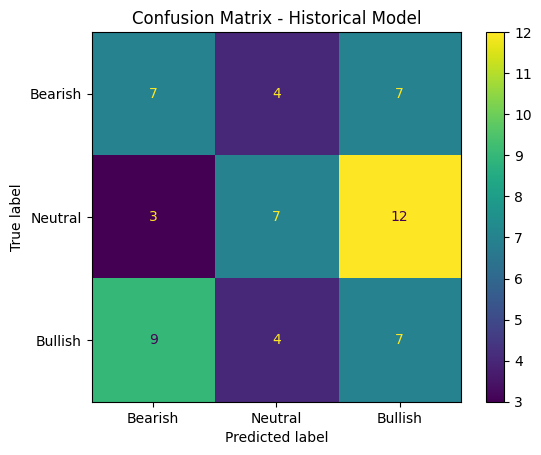

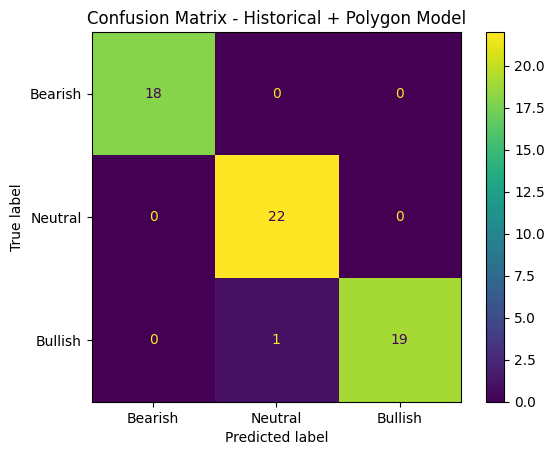

Historical Model:
              precision    recall  f1-score   support

     Bearish       0.37      0.39      0.38        18
     Neutral       0.47      0.32      0.38        22
     Bullish       0.27      0.35      0.30        20

    accuracy                           0.35        60
   macro avg       0.37      0.35      0.35        60
weighted avg       0.37      0.35      0.35        60

Historical + Polygon Model:
              precision    recall  f1-score   support

     Bearish       1.00      1.00      1.00        18
     Neutral       0.96      1.00      0.98        22
     Bullish       1.00      0.95      0.97        20

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [6]:
model1, scaler1 = load_trained_model(
    model_path="eth_lstm_sentiment_model1.pth",
    scaler_path="eth_scaler1.pkl",
    features=features,  # use the features from training
    input_size=len(features)
)

model2, scaler2 = load_trained_model(
    model_path="eth_lstm_sentiment_model2.pth",
    scaler_path="eth_scaler2.pkl",
    features=features,
    input_size=len(features)
)

import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load test CSV
# -----------------------------
df_test = pd.read_csv("eth_combined_updated.csv")
df_test["End"] = pd.to_datetime(df_test["End"])

# Rename columns to lowercase as expected by feature functions
df_test.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume",
    "Market Cap": "market_cap",
    "Start": "start",
    "End": "end",
    "Source": "source"
}, inplace=True)

# -----------------------------
# Feature engineering & labels
# -----------------------------
df_test = add_features(df_test)
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()
df_test = generate_next_day_labels(df_test)[0]

# -----------------------------
# Select last test window
# -----------------------------
test_window = 60
df_test_window = df_test.iloc[-(test_window + SEQ_LEN):]  # include SEQ_LEN for sequences
X_test, y_test = create_sequences(df_test_window, features)  # shape: list/array [num_seq, SEQ_LEN, num_features]

# -----------------------------
# Scale sequences properly
# -----------------------------
def scale_sequences(X, scaler, feature_names):
    num_seq, seq_len, num_feat = X.shape
    X_flat = X.reshape(-1, num_feat)  # flatten to 2D
    # wrap in DataFrame with original feature names
    X_df = pd.DataFrame(X_flat, columns=feature_names)
    X_scaled_flat = scaler.transform(X_df)
    X_scaled = X_scaled_flat.reshape(num_seq, seq_len, num_feat)
    return X_scaled

X_test_scaled1 = scale_sequences(X_test, scaler1, features)
X_test_scaled2 = scale_sequences(X_test, scaler2, features)

# -----------------------------
# Predict function
# -----------------------------
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
    return preds

y_pred1 = predict_model(model1, X_test_scaled1)
y_pred2 = predict_model(model2, X_test_scaled2)

# -----------------------------
# Confusion Matrices
# -----------------------------
labels = ["Bearish", "Neutral", "Bullish"]

cm1 = confusion_matrix(y_test, y_pred1)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=labels)
disp1.plot()
plt.title("Confusion Matrix - Historical Model")
plt.show()

cm2 = confusion_matrix(y_test, y_pred2)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=labels)
disp2.plot()
plt.title("Confusion Matrix - Historical + Polygon Model")
plt.show()

# -----------------------------
# Classification Reports
# -----------------------------
print("Historical Model:")
print(classification_report(y_test, y_pred1, target_names=labels))

print("Historical + Polygon Model:")
print(classification_report(y_test, y_pred2, target_names=labels))



In [7]:
# Number of rows used in test sequences
print("Total test rows selected (including SEQ_LEN):", len(df_test_window))

# Check last few rows
print(df_test_window.tail(10))

# Check label distribution in test window
print("Label counts in test window:")
print(df_test_window['label'].value_counts())

# Optionally, show the ratio of classes in the test window
label_ratios = df_test_window['label'].value_counts(normalize=True).to_dict()
print("Label ratios in test window:", label_ratios)


Total test rows selected (including SEQ_LEN): 120
         source       start        end       open       high        low  \
3699  Coincodex  2025-09-23 2025-09-24  4207.4433  4224.0860  4130.2424   
3700  Coincodex  2025-09-24 2025-09-25  4166.9268  4202.1611  4103.0666   
3701  Coincodex  2025-09-25 2025-09-26  4157.3862  4160.1025  3832.1807   
3702  Coincodex  2025-09-26 2025-09-27  3887.7951  4064.4365  3880.2124   
3703  Coincodex  2025-09-27 2025-09-28  4030.8095  4032.4239  3978.5980   
3704    Polygon  2025-09-28 2025-09-29  4019.6400  4154.3000  3965.7800   
3705    Polygon  2025-09-29 2025-09-30  4143.3600  4250.0000  4084.0000   
3706    Polygon  2025-09-30 2025-10-01  4218.0100  4256.5000  4093.0000   
3707    Polygon  2025-10-01 2025-10-02  4145.9800  4359.7200  4123.3500   
3708    Polygon  2025-10-02 2025-10-03  4350.5200  4530.8500  4335.0100   

          close        volume    market_cap    return  ...        sma_7  \
3699  4168.3032  5.498240e+10  5.051274e+11 -0.00